In [1]:
import os
import json
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageFolder, CelebA
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.io import read_image
from torchvision.transforms.functional import rotate
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

image_size = 224
batch_size = 128
dim = 128
num_classes = 10177 
root = '/kaggle/input/'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform=tt.Compose([
      tt.Resize(image_size),
      tt.CenterCrop(image_size),
      tt.Normalize(*stats)])

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, mode='label'):
      if mode == 'label':
        self.img_labels = pd.read_csv(root+annotations_file, sep=' ', header=None)
      else:
        self.img_labels = pd.read_fwf(root+annotations_file, sep=' ', header=None)
        self.img_labels.columns = cols
      self.img_dir = root+img_dir
      self.transform = transform
      self.mode = mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path).float()/256
        if self.mode == 'label':
          label = self.img_labels.iloc[idx, 1] - 1
        else:
          label = torch.tensor(self.img_labels.iloc[idx, 1:]).float()
        if self.transform:
            shape = image.shape[1:]
            image = self.transform(image)
            if self.mode == 'landmark':
              x_scale = image_size/shape[1]
              y_scale = image_size/shape[0]
              label = label.view(5, 2)
              label[:, 0] *= x_scale
              label[:, 1] *= y_scale
        if self.mode == 'landmark':
          return image, label.view(-1)
        return image, label
    
class Resnet18ft(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    self.enc = nn.Sequential(
        resnet,
        nn.Flatten(),
        nn.Linear(1000, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, dim),
    )

  def forward(self, X):
    X = self.enc(X)
    X = X/torch.norm(X)
    
    return X

class Resnet50ft(nn.Module):
  def __init__(self) -> None:
    super().__init__()
        
    resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
    self.enc = nn.Sequential(
        resnet,
        nn.Flatten(),
        nn.Linear(1000, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, dim)
    )
    
  def forward(self, X):
    X = self.enc(X)
    X = X/torch.norm(X)
    
    return X

class Inception_v3ft(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    self.inception = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
    self.inception.fc = nn.Linear(in_features=2048, out_features=dim)

  def forward(self, X):
    X = self.inception(X)
    X = X/torch.norm(X)
    
    return X

def denorm(image):
  return image*stats[1][0] + stats[0][0]

def get_triplet_batch(dataset, d):
  labels = np.random.randint(num_classes, size=25)
  batch = torch.FloatTensor([]).view(0, 3, image_size, image_size)
  ret = torch.IntTensor([]).view(0,)
  for label in labels:
    slabel = str(label)
    if len(d[slabel]) < 40:
      for i in d[slabel]:
        batch = torch.cat([batch, dataset[i][0].view(-1, 3, image_size, image_size)], axis=0)
      num = torch.zeros(len(d[slabel]), 1)+label
      ret = torch.cat([ret, num])
    else:
      indices = np.random.randint(len(d[slabel]), size=40)
      for it in indices:
        i = d[slabel][it]
        batch = torch.cat([batch, dataset[i][0].view(-1, 3, image_size, image_size)], axis=0)
      num = torch.zeros(40, 1)+label
      ret = torch.cat([ret, num])
  perm = torch.randperm(batch.shape[0])
  batch = batch[perm]
  ret = ret[perm]

  return batch, ret

def get_hard_triplets(batch, labels):
  all_dists = torch.sqrt(torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2))
  print(all_dists.max())
  same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)))
  pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0])))
  pos_indices = torch.argmax(all_dists * pos_mask, axis=1)
  all_dists[same_label_mask] = 1e9
  neg_indices = torch.argmin(all_dists, axis=1)
  
  return torch.arange(batch.shape[0]), pos_indices, neg_indices

# def get_semi_hard_triplets(batch, labels):
#   all_dists = torch.sqrt(torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2))
#   print(all_dists.max())
#   same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)))
#   pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0]))) * (all_dists < 0.2)
#   pos_i = torch.argmax(all_dists * pos_mask, axis=1)
#   pos_indices = torch.arange(labels.shape[0]).repeat(labels.shape[0], 1)[pos_mask]
#   pos_dists = all_dists[np.arange(all_dists.shape[0]), pos_i]
#   all_dists[all_dists <= pos_dists.reshape((-1, 1))] = 1e9
#   neg_indices = torch.argmin(all_dists, axis=1)
#   repeat = torch.sum(torch.ones(labels.shape[0], labels.shape[0])*pos_mask, axis=1)
#   anc_indices = torch.repeat_interleave(torch.arange(batch.shape[0]), repeat.int())
#   neg_indices = torch.repeat_interleave(neg_indices, repeat.int())
#   print(anc_indices.shape)
#   sample = np.random.choice(anc_indices.shape[0], replace=False, size=500)
  
#   return anc_indices[sample], pos_indices[sample], neg_indices[sample]

def get_semi_hard_triplets(batch, labels):
  all_dists = torch.sqrt(torch.sum(torch.pow(batch.unsqueeze(1) - batch.unsqueeze(0), 2), axis=2))
  print(all_dists.max())
  same_label_mask = torch.squeeze(torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)))
  pos_mask = torch.squeeze(torch.logical_xor(same_label_mask, torch.eye(labels.size()[0])))
  pos_indices = torch.argmax(all_dists * pos_mask, axis=1)
  all_dists[same_label_mask] = 1e9
  all_dists[all_dists > all_dists[:, pos_indices] + 0.2] = 1e9
  all_dists[all_dists < all_dists[:, pos_indices]] = 1e9
  neg_indices = torch.argmin(all_dists, axis=1)
  
  return torch.arange(batch.shape[0]), pos_indices, neg_indices

def get_dataloader(batch):
    return DataLoader(batch, batch_size=batch_size)

def get_embeddings(model, batch, device):
    dl = get_dataloader(batch)
    it = iter(dl)
    emb = torch.FloatTensor([]).view(0, dim)
    for i in it:
        with torch.no_grad():
            e = model(i.to(device))
        emb = torch.cat([emb, e.cpu()], axis=0)
    
    return emb
        
        

def make_triplets(batch, a, p, n):
    a = batch[a].view(-1, 1, 3, image_size, image_size)
    p = batch[p].view(-1, 1, 3, image_size, image_size)
    n = batch[n].view(-1, 1, 3, image_size, image_size)
    triplets = torch.cat([a, p, n], axis=1)
    
    return triplets
    
def get_triplets_dataloader(batch, a, p, n):
    triplets = make_triplets(batch, a, p, n)
    print(triplets.shape)
    dataloader = DataLoader(triplets, batch_size=batch_size)
    
    return dataloader

def trl(a, p, n):
  return nn.TripletMarginLoss(margin=0.2)(a, p, n)

def fit(model, opt, scheduler, train_dataset, val_dataset, d_train, d_val, n_epochs, device):
  train_losses_per_epoch = []
  val_losses_per_epoch = []
  train_losses = []
  val_losses = []
  
  for epoch in tqdm(range(n_epochs)):
    model.train()
    batch, labels = get_triplet_batch(train_dataset, d_train)
#     print(torch.cuda.memory_summary())
    emb = get_embeddings(model, batch, device)
#     print(torch.cuda.memory_summary())
    anc, pos, neg = get_semi_hard_triplets(emb, labels)
    loader = get_triplets_dataloader(batch, anc, pos, neg)
    a = torch.FloatTensor([]).view(0, dim)
    p = torch.FloatTensor([]).view(0, dim)
    n = torch.FloatTensor([]).view(0, dim)
    it = iter(loader)
    opt.zero_grad()
#     print(torch.cuda.memory_summary())
    
    for i in it:
        anc = model(i[:, 0, :, :, :].to(device))
#         print(torch.cuda.memory_summary())
        pos = model(i[:, 1, :, :, :].to(device))
        neg = model(i[:, 2, :, :, :].to(device))
#         a = torch.cat([a, anc.cpu()], dim=0)
#         p = torch.cat([p, pos.cpu()], dim=0)
#         n = torch.cat([n, neg.cpu()], dim=0)
        loss = trl(anc, pos, neg)
        loss.backward()
        opt.step()
        train_losses_per_epoch.append(loss.item())
    scheduler.step()
    train_losses.append(np.array(train_losses_per_epoch).mean())
  
    model.eval()
    batch, labels = get_triplet_batch(train_dataset, d_train)
    emb = get_embeddings(model, batch, device)
    anc, pos, neg = get_hard_triplets(emb, labels)
    loader = get_triplets_dataloader(batch, anc, pos, neg)
    a = torch.FloatTensor([]).view(0, dim)
    p = torch.FloatTensor([]).view(0, dim)
    n = torch.FloatTensor([]).view(0, dim)
    it = iter(loader)
    with torch.no_grad():
        for i in it:
            if i.shape[0] == 1:
                continue
            anc = model(i[:, 0, :, :, :].to(device))
            pos = model(i[:, 1, :, :, :].to(device))
            neg = model(i[:, 2, :, :, :].to(device))
#             a = torch.cat([a, anc.cpu()], dim=0)
#             p = torch.cat([p, pos.cpu()], dim=0)
#             n = torch.cat([n, neg.cpu()], dim=0)
            loss = trl(anc, pos, neg)
            val_losses_per_epoch.append(loss.item())
    val_losses.append(np.array(val_losses_per_epoch).mean())    
  return train_losses, val_losses

def plot_tsne(model, data, d, device):
    batch, labels = get_triplet_batch(data, d)
    emb = get_embeddings(model, batch, device).cpu()
    
    from sklearn.manifold import TSNE
    reduced = TSNE().fit_transform(emb)
    arr = np.arange(labels[-1])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.scatter(reduced[:, 0], reduced[:, 1], c=labels)
    ax.legend()

In [ ]:
b, l = get_triplet_batch(dataset, d)
emb = get_embeddings(model, b, device)
a, p, n = get_semi_hard_triplets(emb, l, device)
# loader = get_triplets_dataloader(b, a, p, n)

In [ ]:
loader = get_triplets_dataloader(b, a, p, n)

In [2]:
dataset = CustomImageDataset('identity-celeba/identity_CelebA.txt', 'celeba-dataset/img_align_celeba/img_align_celeba', transform, mode='label')
with open(root+'celeba-pics-per-identity-dict/d.json'
          , "r") as f:
    d = json.loads(f.read())

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
model = Resnet50ft().to(device)
counter = 0
for child in model.children():
  for param in child.parameters():
    if counter <= 130:
      param.requires_grad = False
      print("frozen")
      counter += 1
    else: 
      print("not frozen")
model.load_state_dict(torch.load('/kaggle/input/notebook6fb608a4ab/face_recognition_resnet50ft_semi_hard.pt'))
opt = torch.optim.Adam(model.parameters(), lr=3e-4)
opt.load_state_dict(torch.load('/kaggle/input/notebook6fb608a4ab/face_recognition_resnet50ft_semi_hard_opt.pt'))
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=1)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
frozen
not frozen
not frozen
not frozen
not frozen
not frozen
not frozen
not frozen
not fr

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
for i, fig_x in enumerate(ax.flatten()):
    fig_x.imshow(denorm(dataset[d['1337'][i]][0].permute(1, 2, 0)))

In [8]:
torch.save(model.state_dict(), '/kaggle/working/face_recognition_resnet50ft_semi_hard.pt')
torch.save(opt.state_dict(), '/kaggle/working/face_recognition_resnet50ft_semi_hard_opt.pt')

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(0.1799)
torch.Size([551, 3, 3, 224, 224])
tensor(0.1139)
torch.Size([511, 3, 3, 224, 224])
tensor(0.1149)
torch.Size([501, 3, 3, 224, 224])
tensor(0.1315)
torch.Size([448, 3, 3, 224, 224])
tensor(0.1467)
torch.Size([569, 3, 3, 224, 224])
tensor(0.6319)
torch.Size([561, 3, 3, 224, 224])
tensor(0.1239)
torch.Size([489, 3, 3, 224, 224])
tensor(0.1264)
torch.Size([634, 3, 3, 224, 224])
tensor(0.1296)
torch.Size([476, 3, 3, 224, 224])
tensor(0.1423)
torch.Size([468, 3, 3, 224, 224])
tensor(0.6782)
torch.Size([514, 3, 3, 224, 224])
tensor(0.1528)
torch.Size([481, 3, 3, 224, 224])
tensor(0.1484)
torch.Size([556, 3, 3, 224, 224])
tensor(0.1323)
torch.Size([478, 3, 3, 224, 224])
tensor(0.1377)
torch.Size([441, 3, 3, 224, 224])
tensor(0.1697)
torch.Size([494, 3, 3, 224, 224])
tensor(0.2037)
torch.Size([542, 3, 3, 224, 224])
tensor(0.6107)
torch.Size([516, 3, 3, 224, 224])
tensor(0.1866)
torch.Size([494, 3, 3, 224, 224])
tensor(0.8736)
torch.Size([436, 3, 3, 224, 224])
tensor(0.1792)
torch

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


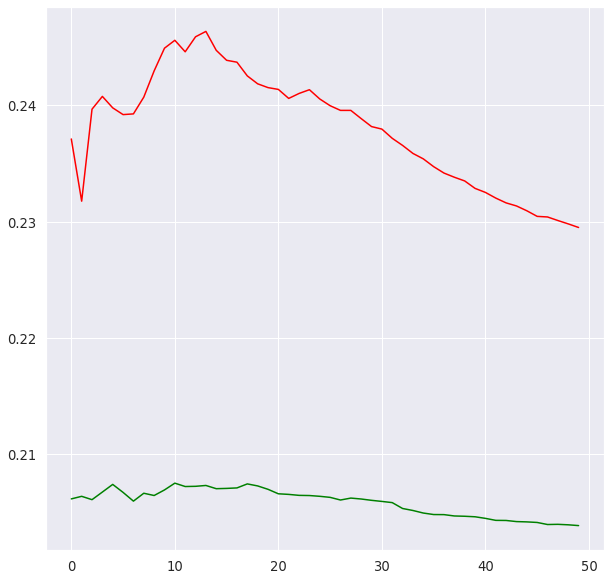

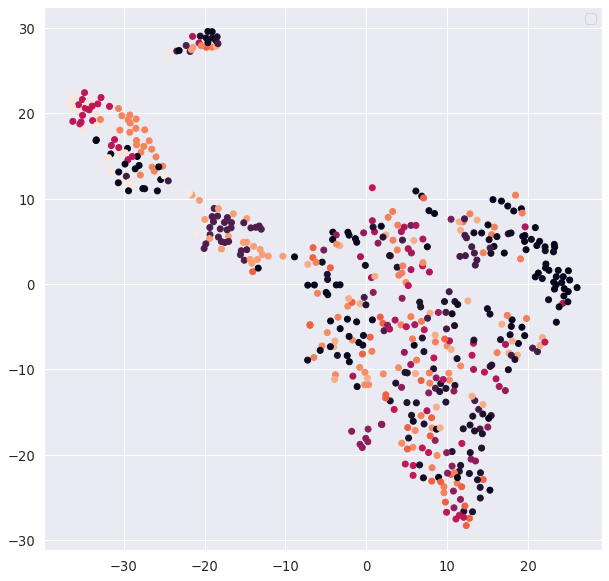

In [5]:
train_losses, val_losses = fit(model, opt, scheduler, dataset, dataset, d, d, 50, device)
torch.save(model.state_dict(), '/kaggle/working/face_recognition_resnet50ft_semi_hard.pt')
torch.save(opt.state_dict(), '/kaggle/working/face_recognition_resnet50ft_semi_hard_opt.pt')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.plot(np.arange(len(train_losses)), train_losses, color='green')
ax.plot(np.arange(len(val_losses)), val_losses, color='red')
plot_tsne(model, dataset, d, device)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


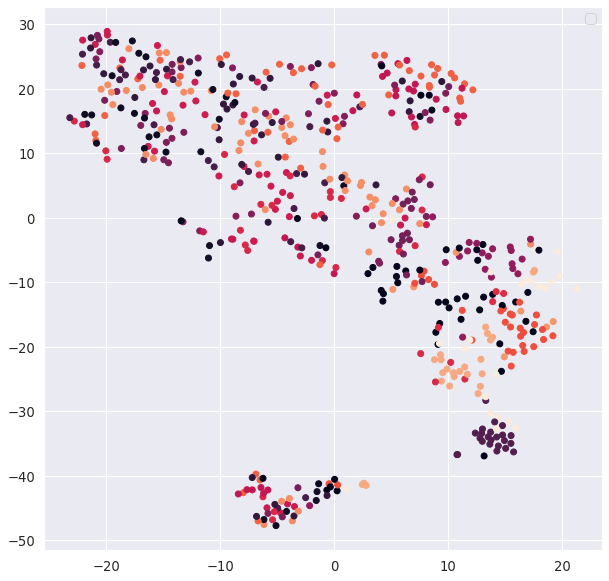

In [9]:
plot_tsne(model, dataset, d, device)